# Dec 2st, 2021 (GSR, NMF, etc)

**Motivation**: Some figures made for today's group meeting. Preprocessing related. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def collect_adjacencies(mice, mode):
    proc, *_ = mice.get_data_containers(mode)

    adjacencies, dirs = [], {}
    for key in proc:
        sub, ses, run = mice.looper[key]
        if run == -1:
            continue
        net = Network(mice, key, mode).load_network()
        adjacencies.append(np.expand_dims(net.adj, 0))
        dirs[key] = pjoin(mice.cfg.results_dir, 'Network', net.base_name)

    adjacencies = np.concatenate(adjacencies)
    return adjacencies, dirs


def calculate_portraits(adj, thres, save_dir: str = None, force_fit: bool = False):
    if save_dir is not None and not force_fit:
        load_file = pjoin(save_dir, 'portraits')
        if os.path.isfile(load_file):
            portraits = np.load(load_file, allow_pickle=True)
            return portraits.item()

    portraits = {}
    nonzero = np.abs(adj).mean(0) > 0
    for i, th in enumerate(thres):
        adj_eff = adj[nonzero][:, nonzero]
        adj_eff[adj_eff <= th] = 0
        adj_eff[adj_eff > th] = 1
        g = nx.from_numpy_matrix(adj_eff)
        if save_dir is not None:
            fname = '_'.join(save_dir.split('_')[-3:])
            fname = f"{fname}_no{i:03d}_th{th:0.7f}"
        else:
            fname = None
        portraits[(i, th)] = portrait_cpp(g, fname)

    if save_dir is not None:
        save_obj(
            obj=portraits,
            file_name='portraits',
            save_dir=save_dir,
            mode='npy',
            verbose=False,
        )
    return portraits


def calculate_portrait_divergece(portraits_list):
    div = np_nans((len(portraits_list), len(portraits_list)))
    for i, j in itertools.combinations(range(len(portraits_list)), 2):
        div[i, j] = portrait_divergence(portraits_list[i], portraits_list[j])
    return div

## Portrait Divergence

### on synthetic graphs

In [3]:
sys.path.insert(0, pjoin(git_dir, 'network-portrait-divergence'))
from portrait_divergence import portrait_divergence, portrait_py, portrait_cpp

In [4]:
Ger1  = nx.erdos_renyi_graph(100, 3/99)
Ger2  = nx.erdos_renyi_graph(100, 3/99)
Gba1 = nx.barabasi_albert_graph(100, 3)
Gba2 = nx.barabasi_albert_graph(100, 3)

print("Djs(ER1,ER2) =", portrait_divergence(Ger1, Ger2))
print("Djs(ER1,BA1) =", portrait_divergence(Ger1, Gba1))
print("Djs(ER1,BA2) =", portrait_divergence(Ger1, Gba2))
print("Djs(BA1,BA2) =", portrait_divergence(Gba1, Gba2))

Djs(ER1,ER2) = 0.3428942986544757

Djs(ER1,BA1) = 0.8881401024371357

Djs(ER1,BA2) = 0.8414243180742774

Djs(BA1,BA2) = 0.23688325561906196

### On real graphs (ca2)

In [5]:
mice = Mice((768, 4))
mice.setup_func_data('rest')

In [6]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2')
adjacencies.shape

(114, 996, 996)

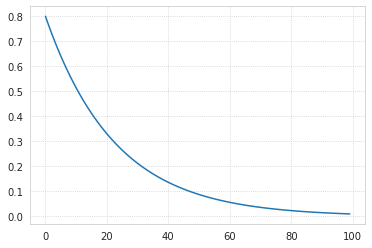

In [7]:
start = 0.80
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [8]:
densities

array([0.8       , 0.76536193, 0.7322236 , 0.70052009, 0.67018926,
       0.64117168, 0.61341049, 0.5868513 , 0.56144205, 0.53713296,
       0.5138764 , 0.49162679, 0.47034054, 0.44997593, 0.43049306,
       0.41185374, 0.39402147, 0.37696129, 0.36063978, 0.34502494,
       0.3300862 , 0.31579426, 0.30212113, 0.28904001, 0.27652528,
       0.2645524 , 0.25309792, 0.24213939, 0.23165534, 0.22162522,
       0.21202938, 0.20284902, 0.19406615, 0.18566355, 0.17762477,
       0.16993405, 0.16257631, 0.15553715, 0.14880277, 0.14235996,
       0.13619612, 0.13029916, 0.12465752, 0.11926015, 0.11409647,
       0.10915637, 0.10443016, 0.09990859, 0.09558279, 0.09144428,
       0.08748497, 0.08369708, 0.0800732 , 0.07660622, 0.07328936,
       0.0701161 , 0.06708025, 0.06417583, 0.06139717, 0.05873882,
       0.05619557, 0.05376244, 0.05143466, 0.04920766, 0.04707709,
       0.04503876, 0.04308869, 0.04122306, 0.0394382 , 0.03773062,
       0.03609697, 0.03453406, 0.03303882, 0.03160832, 0.03023976,
       0.02893045, 0.02767783, 0.02647945, 0.02533295, 0.02423609,
       0.02318673, 0.0221828 , 0.02122234, 0.02030346, 0.01942437,
       0.01858334, 0.01777873, 0.01700895, 0.01627251, 0.01556795,
       0.01489389, 0.01424902, 0.01363207, 0.01304184, 0.01247716,
       0.01193693, 0.01142009, 0.01092562, 0.01045257, 0.01      ])